# Let´s recommend!!

We will load the model that generate candidates and create a function that receives a customer as input and returns a top of N products to be recommended. We will evaluate the results afterwords.

In [1]:
import pandas as pd
import os, sys
import numpy as np
import seaborn as sns
import gc
import warnings
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from gensim.models import Word2Vec

In [2]:
path = os.path.join('../../Data/')
data = pd.read_csv(path + 'data_filtered_20190422.csv', sep = ';')
data_processed = pd.read_csv('data_final_20190524.csv')
data_processed['text'] = data_processed['text'].astype(str)

In [3]:
items_unique = data_processed.item_id.unique()
items_map = {i:val for i,val in enumerate(items_unique)}
items_map_inv = {val:i for i,val in enumerate(items_unique)}
items_map_text = data_processed.set_index('item_id_int').text.to_dict()

In [4]:
idx_customers_map = {i:val for i,val in enumerate(data_processed['customer_id_int'])}
idx_customers_df = pd.DataFrame({'idx': data_processed.index.values, 'customer_id_int': data_processed.customer_id_int})

In [5]:
data.head(3)

,item_id,availability_date,brand,category,name,price
0,A28233506,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo masculino con textura de mujer,"{'final': 199, 'currency': 'EUR'}"
1,A29054782,NaN,Woman Limited El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo doble faz de mujer con cinturón a tono,"{'final': 149, 'currency': 'EUR'}"
2,A27354432,NaN,Woman El Corte Inglés,"['Moda', 'Mujer', 'Abrigos']",Abrigo largo de antelina de mujer Woman El Cor...,"{'final': 89.99, 'currency': 'EUR'}"


In [6]:
data_processed.head(3)

,date,item_id,brand,PRICE,customer_id,text,item_age,customer_id_int,item_id_int,brand_id,score,score_original,power_price,power_score,power_item_age,sqrt_price,sqrt_score,sqrt_item_age
0,20190101,A26036172,tintoretto,0.002036,0,vestido mujer flor lazada,0.0,0,0,0,0.003296,8,0.000004,0.000011,0.0,0.045126,0.057408,0.0
1,20190115,A26036172,tintoretto,0.002036,0,vestido mujer flor lazada,0.0,0,0,0,0.003296,8,0.000004,0.000011,0.0,0.045126,0.057408,0.0
2,20190101,A26870590,fórmula joven,0.001444,0,vestido laminado mujer formula joven escote pico,0.0,0,1,1,0.001412,4,0.000002,0.000002,0.0,0.037997,0.037582,0.0


In [7]:
MAX_NB_WORDS = 30_000 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 24 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 100 #Same dim as our W2V embedding

all_text = data_processed['text']
all_text = all_text.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_text)

data_sequences = tokenizer.texts_to_sequences(data_processed['text'])
data_vec = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13046 unique tokens.


In [30]:
model = load_model('candidate_generation_20190524')

## Predictions

In [83]:
def diversify(arr, diversity, plot = False):
    div = np.log(arr) / diversity
    exp_preds = np.exp(div)
    preds = exp_preds / np.sum(exp_preds)
    if plot:
        plt.figure(figsize = (10, 8));
        plt.subplot(2, 1, 1);
        sns.distplot(arr); plt.title('Original Distribution');
        plt.subplot(2, 1, 2);
        sns.distplot(preds); plt.title(f'Distribution with {diversity} diversity')
    probas = np.random.multinomial(1, preds, 1)
    return probas

In [105]:
def recommend(customer, N = 5):
    try:
        _data = data_processed[data_processed['customer_id_int'] == customer]
        _data_vec = data_vec[_data.index]
        _pred = model.predict([_data['customer_id_int'], _data['item_id_int'], 
                             _data['brand_id'], _data['PRICE'],
                             _data_vec, _data['item_age'], _data['score'],
                             _data['power_price'], _data['power_score'], _data['power_item_age'],
                             _data['sqrt_price'], _data['sqrt_score'], _data['sqrt_item_age']],
                             verbose = 1)
        _pred = pd.DataFrame(_pred)
        _pred['customer_id_int'] = customer
        _pred = _pred.groupby(['customer_id_int']).max()
    #########################################################
        #_pred = diversify(_pred.values.reshape(_pred.shape[1]), diversity = 0.01, plot = False)
        #print(_pred.)
        print('\n' + '=='*30 + '\n')
        print(f'==> Top {N} Recommended items to Customer {customer}: ')
        print(f'\nThe customer {customer} has bought this items: ')
        print('\n' + '=='*30 + '\n')
        interacted_items = data_processed[['text', 'score_original']][data_processed['customer_id_int'] == customer].groupby('text')\
                            .sum().reset_index().sort_values(['score_original'], ascending = False)
        print('\n'.join([str(i+1) + str(' - ') + str(x) for i, x in enumerate(interacted_items['text'].values[0:20])]))
        top = _pred.values.reshape(_pred.shape[1]).argsort()[-N:][::-1] #items positions
        print('\n====================== IDs DE PRODUCTOS RECOMENDADOS ==============')
        print([items_map[item] for item in top])
        print ("\n===================== PRODUCTOS RECOMENDADOS =====================")
        print('\n'.join([str(i+1) + str(' - ') + str(items_map_text[x]) for i, x in enumerate(top)]))
        print ("==================================================================")
    except:
        print(f'\nThe customer {customer} does not exist')

In [109]:
CUSTOMER = 404
recommend(customer = CUSTOMER, N = 10)

39/39 [==============================] - 0s 1ms/sample


==> Top 10 Recommended items to Customer 404: 

The customer 404 has bought this items: 


1 - camison kitch moon river largo tirante
2 - reloj mujer agatha ruiz flip agr36 pvc blanco
3 - camison cenefa bordada
4 - reloj mujer malla acero
5 - reloj mujer olivia ob16eg113 piel azul
6 - camison corto guipur
7 - reloj mujer olivia ob16sg06 piel gris
8 - reloj mujer thom olson gypset cbto021 piel negro
9 - mantel estampado floral indiana corte_ingles
10 - camison novia moon river encaje blanco
11 - charm colgante corazon madre hija plata circonita esmalte
12 - tv led centimetro 43pus670312 4k smart saphi ultraplano ambilight lado
13 - tv led centimetro 43pft550312 full hd ultraplano pixel plus
14 - camiseta hombre tanken north face
15 - tv led centimetro 43uk6500 uhd 4k smart inteligencia artificial ia hdr
16 - pulsera mujer
17 - watch serie gps 38mm caja aluminio plata correa deportiva blanca
18 - watch serie gps 42mm caja aluminio 

323/323 [==============================] - 0s 1ms/sample


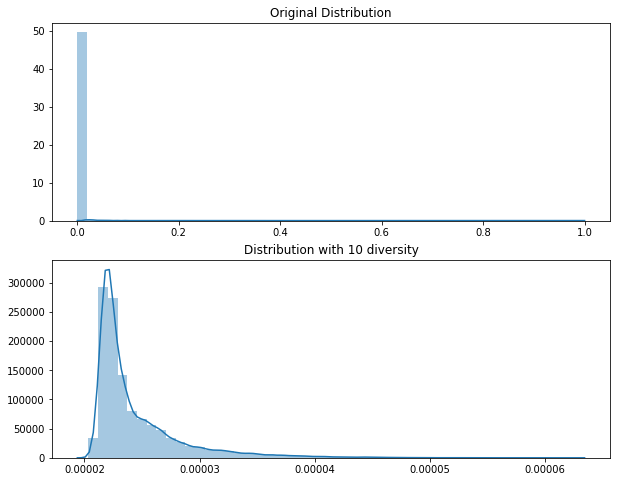

In [97]:
customer = 0
_data = data_processed[data_processed['customer_id_int'] == 0]
_data_vec = data_vec[_data.index]
_pred = model.predict([_data['customer_id_int'], _data['item_id_int'], 
                     _data['brand_id'], _data['PRICE'],
                     _data_vec, _data['item_age'], _data['score'],
                     _data['power_price'], _data['power_score'], _data['power_item_age'],
                     _data['sqrt_price'], _data['sqrt_score'], _data['sqrt_item_age']],
                     verbose = 1)
_pred = pd.DataFrame(_pred)
_pred['customer_id_int'] = customer
_pred = _pred.groupby(['customer_id_int']).max()
a = diversify(_pred.values.reshape(_pred.shape[1]), diversity = 10, plot = True)

In [98]:
a.shape

(1, 40965)

---

In [ ]:
test_pred = model.predict([data_processed['customer_id_int'], data_processed['item_id_int'], 
                     data_processed['brand_id'], data_processed['PRICE'],
                     data_vec, data_processed['item_age'], data_processed['score'],
                     data_processed['power_price'], data_processed['power_score'], data_processed['power_item_age'],
                     data_processed['sqrt_price'], data_processed['sqrt_score'], data_processed['sqrt_item_age']],
                     verbose = 1)

In [ ]:
#prueba = pd.DataFrame(test_pred)
#customers = data_processed['customer_id_int'].values
#prueba['customer_id_int'] = customers
#prueba = prueba.sample(frac = 0.4)
#prueba = prueba.groupby(['customer_id_int']).max()
#del prueba.index.name
#print(prueba.shape)
#prueba.head()

In [ ]:

test_pred = pd.DataFrame(test_pred)
customers = data_processed['customer_id_int'].values
test_pred['customer_id_int'] = customers
test_pred = test_pred.sample(frac = 0.4) #In order to dont have allocation problems
test_pred = test_pred.groupby(['customer_id_int']).max()
del test_pred.index.name
        
print(test_pred.shape)
test_pred.head()

In [ ]:
def get_afines(data_pred, customer, items_unique, N = 5):
    try:
        #data_pred = diversify(data_pred.loc[cliente] , diversity = 0.25)
        #data_pred = data_pred.reshape(len(items_unique))
        print(f'==> Top {N} Recommended items to Customer {customer}: ')
        print(f'\nThe customer {customer} has bought this items: ')
        print('\n' + '=='*30 + '\n')
        interacted_items = data_processed[['text', 'score_original']][data_processed['customer_id_int'] == customer].groupby('text')\
                            .sum().reset_index().sort_values(['score_original'], ascending = False)
        print('\n'.join([str(i+1) + str(' - ') + str(x) for i, x in enumerate(interacted_items['text'].values[0:30])]))
        top = data_pred[customer].values.argsort()[-N:][::-1] #items positions
        print('\n====================== IDs DE PRODUCTOS RECOMENDADOS ==============')
        print([items_map[item] for item in top])
        print ("\n===================== PRODUCTOS RECOMENDADOS =====================")
        print('\n'.join([str(i+1) + str(' - ') + str(items_map_text[x]) for i, x in enumerate(top)]))
        print ("==================================================================")
    except:
        print(f'The customer {customer} does not exist')

In [ ]:
CLIENTE = 12
get_afines(data_pred = test_pred, customer = CLIENTE, items_unique = items_unique, N = 10)
#data_processed[data_processed['customer_id_int'] == CLIENTE]